In [1]:
# To support both python 2 and python 3
# 让这份笔记同步支持 python 2 和 python 3
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
#使用statsmodels便于统计分析数据
import statsmodels.api as sm
import statsmodels.formula.api as smf
#使用sklearn便于预测（机器学习）
from sklearn import linear_model
#使用patsy便于生成模型
import patsy

**11. We will now try to predict per capita crime rate in the Boston data
set.
(a) Try out some of the regression methods explored in this chapter,
such as best subset selection, the lasso, ridge regression, and
PCR. Present and discuss results for the approaches that you
consider.**

In [3]:
Boston = pd.read_csv("data/Boston.csv")
Boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


**最优子集选择法**

In [4]:
#实现一个按照RSS（或者其他评估）来量化的regsubsets函数
import itertools
def regsubsets(model,dataset,nvmax = 8,method = 'full',scale = 'rss'):
    y,X = patsy.dmatrices(model, data = dataset, return_type="dataframe")
    X_columns = list(X.columns)
    try:
        X_columns.remove('Intercept')
    except:
        pass
    if nvmax > len(X_columns):
        nvmax = len(X_columns)
    all_data_dict = {}
    if method == 'full':
        for nv in range(1,nvmax + 1):
            nv_scale = None
            nv_result = {}
            for X_columns_nv in itertools.combinations(X_columns,nv):
                X_columns_nv = list(X_columns_nv)
                X_model = sm.add_constant(X[X_columns_nv])
                results = sm.OLS(y, X_model).fit()
                nv_result['rss'] = results.ssr
                nv_result['rsq'] = -results.rsquared
                nv_result['adjr2'] = -results.rsquared_adj
                nv_result['cp'] = results.aic
                nv_result['bic'] = results.bic
                if nv_scale == None or nv_scale > nv_result[scale]:
                    nv_scale = nv_result[scale]
                    nv_X_columns = X_columns_nv
            X_model = sm.add_constant(X[nv_X_columns])
            results = sm.OLS(y, X_model).fit()
            all_data_dict[nv] = {}
            all_data_dict[nv]['X_columns'] = nv_X_columns
            all_data_dict[nv]['rss'] = results.ssr
            all_data_dict[nv]['rsq'] = results.rsquared
            all_data_dict[nv]['adjr2'] = results.rsquared_adj
            all_data_dict[nv]['cp'] = results.aic
            all_data_dict[nv]['bic'] = results.bic
            all_data_dict[nv]['params'] = results.params
    elif method == 'forward':
        all_data_dict[0] = {}
        all_data_dict[0]['X_columns'] = []
        for nv in range(1,nvmax + 1):
            nv_scale = None
            nv_result = {}
            X_columns_others = X_columns.copy()
            for column_value in all_data_dict[nv - 1]['X_columns']:
                X_columns_others.remove(column_value)
            for column_value in X_columns_others:
                X_columns_nv = all_data_dict[nv - 1]['X_columns'].copy()
                X_columns_nv.append(column_value)
                X_model = sm.add_constant(X[X_columns_nv])
                results = sm.OLS(y, X_model).fit()
                nv_result['rss'] = results.ssr
                nv_result['rsq'] = -results.rsquared
                nv_result['adjr2'] = -results.rsquared_adj
                nv_result['cp'] = results.aic
                nv_result['bic'] = results.bic
                if nv_scale == None or nv_scale > nv_result[scale]:
                    nv_scale = nv_result[scale]
                    nv_X_columns = X_columns_nv
            X_model = sm.add_constant(X[nv_X_columns])
            results = sm.OLS(y, X_model).fit()
            all_data_dict[nv] = {}
            all_data_dict[nv]['X_columns'] = nv_X_columns
            all_data_dict[nv]['rss'] = results.ssr
            all_data_dict[nv]['rsq'] = results.rsquared
            all_data_dict[nv]['adjr2'] = results.rsquared_adj
            all_data_dict[nv]['cp'] = results.aic
            all_data_dict[nv]['bic'] = results.bic
            all_data_dict[nv]['params'] = results.params
        del all_data_dict[0]
    elif method == 'backward':
        for nv in reversed(range(1,len(X_columns) + 1)):
            nv_scale = None
            nv_result = {}
            if nv == len(X_columns):
                nv_X_columns = X_columns
            else:
                for column_value in all_data_dict[nv + 1]['X_columns']:
                    X_columns_nv = all_data_dict[nv + 1]['X_columns'].copy()
                    X_columns_nv.remove(column_value)
                    X_model = sm.add_constant(X[X_columns_nv])
                    results = sm.OLS(y, X_model).fit()
                    nv_result['rss'] = results.ssr
                    nv_result['rsq'] = -results.rsquared
                    nv_result['adjr2'] = -results.rsquared_adj
                    nv_result['cp'] = results.aic
                    nv_result['bic'] = results.bic
                    if nv_scale == None or nv_scale > nv_result[scale]:
                        nv_scale = nv_result[scale]
                        nv_X_columns = X_columns_nv
            X_model = sm.add_constant(X[nv_X_columns])
            results = sm.OLS(y, X_model).fit()
            all_data_dict[nv] = {}
            all_data_dict[nv]['X_columns'] = nv_X_columns
            all_data_dict[nv]['rss'] = results.ssr
            all_data_dict[nv]['rsq'] = results.rsquared
            all_data_dict[nv]['adjr2'] = results.rsquared_adj
            all_data_dict[nv]['cp'] = results.aic
            all_data_dict[nv]['bic'] = results.bic
            all_data_dict[nv]['params'] = results.params
            for nv in range(nvmax + 1,len(X_columns) + 1):
                del all_data_dict[nv]
    return pd.DataFrame(all_data_dict).T.sort_index()

In [5]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(Boston,test_size=0.2, random_state=427)

In [6]:
columns_value = '0'
for column_value in Boston.columns:
    columns_value = columns_value + '+' + column_value
model = 'crim ~ {} - crim'.format(columns_value)
y_train,X_train = patsy.dmatrices(model,data = train_set,return_type="dataframe")
y_test,X_test = patsy.dmatrices(model,data = test_set,return_type="dataframe")
#需要分析的最大模型数
nvmax = 13
reg = regsubsets(model,train_set,nvmax)

c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [7]:
reg.head()

,X_columns,rss,rsq,adjr2,cp,bic,params
1,[rad],14821.1,0.391307,0.389793,2605.87,2613.87,const -2.070764 rad 0.560026 dtype: flo...
2,"[rad, lstat]",14012.1,0.424532,0.421662,2585.19,2597.2,const -4.109411 rad 0.471244 lstat 0...
3,"[zn, rad, lstat]",13933.4,0.427761,0.423469,2584.92,2600.92,const -4.753175 zn 0.020747 rad 0...
4,"[zn, dis, rad, lstat]",13840,0.431597,0.425899,2584.2,2604.21,const -3.259737 zn 0.036358 dis -0...
5,"[zn, dis, rad, lstat, medv]",13725.6,0.436297,0.429215,2582.85,2606.85,const 0.451022 zn 0.044243 dis -0...


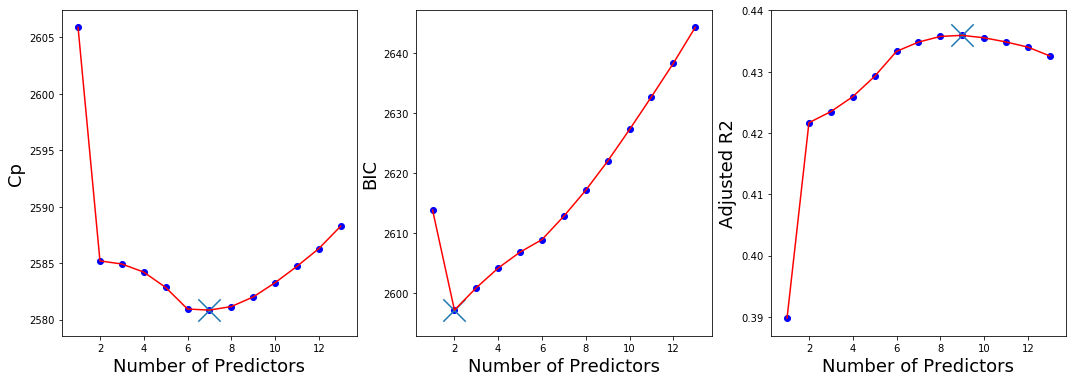

In [8]:
num_range = range(1,nvmax + 1)
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.plot(num_range,reg['cp'],'r-')
plt.scatter(num_range,reg['cp'],color = 'b')
plt.scatter(reg['cp'].astype('float64').idxmin(),reg['cp'].min(),marker = 'x',s=500)
plt.xlabel(u"Number of Predictors", fontsize=18)
plt.ylabel(u"Cp", fontsize=18)
plt.subplot(132)
plt.plot(num_range,reg['bic'],'r-')
plt.scatter(num_range,reg['bic'],color = 'b')
plt.scatter(reg['bic'].astype('float64').idxmin(),reg['bic'].min(),marker = 'x',s=500)
plt.xlabel(u"Number of Predictors", fontsize=18)
plt.ylabel(u"BIC", fontsize=18)
plt.subplot(133)
plt.plot(num_range,reg['adjr2'],'r-')
plt.scatter(num_range,reg['adjr2'],color = 'b')
plt.scatter(reg['adjr2'].astype('float64').idxmax(),reg['adjr2'].max(),marker = 'x',s=500)
plt.xlabel(u"Number of Predictors", fontsize=18)
plt.ylabel(u"Adjusted R2", fontsize=18)
plt.show()

In [9]:
reg_num_cp = int(reg['cp'].astype('float64').idxmin())
reg_num_bic = int(reg['bic'].astype('float64').idxmin())
reg_num_adjr2 = int(reg['adjr2'].astype('float64').idxmax())
print('number of Predictors with min of cp: ',reg_num_cp)
print('number of Predictors with min of bic: ',reg_num_bic)
print('number of Predictors with max of adjr2: ',reg_num_adjr2)

number of Predictors with min of cp:  7
number of Predictors with min of bic:  2
number of Predictors with max of adjr2:  9


**LASSO方法**

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
std_scaler = StandardScaler(with_mean=False)
std_scaler.fit(X_train)
X_train_Standard = std_scaler.transform(X_train)
param_grid = [
{'alpha': 10 ** np.linspace(2, -4, 100) },
]
lasso_reg = Lasso(random_state = 1)
lasso_grid_search = GridSearchCV(lasso_reg, param_grid, cv = 10, scoring='neg_mean_squared_error')
lasso_grid_search.fit(X_train_Standard ,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=1,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e+02, 8.69749003e+01, 7.56463328e+01, 6.57933225e+01,
       5.72236766e+01, 4...
       1.41747416e-03, 1.23284674e-03, 1.07226722e-03, 9.32603347e-04,
       8.11130831e-04, 7.05480231e-04, 6.13590727e-04, 5.33669923e-04,
       4.64158883e-04, 4.03701726e-04, 3.51119173e-04, 3.05385551e-04,
       2.65608778e-04, 2.31012970e-04, 2.00923300e-04, 1.74752840e-04,
       1.51991108e-04, 1.32194115e-04, 1.14975700e-04, 1.00000000e-04])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

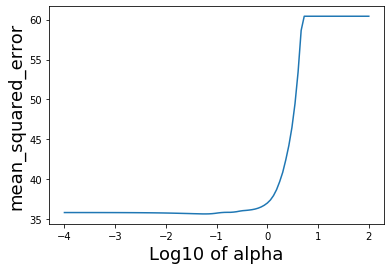

In [11]:
plt.plot(np.linspace(2, -4, 100),-lasso_grid_search.cv_results_["mean_test_score"])
plt.xlabel("Log10 of alpha", fontsize=18)
plt.ylabel("mean_squared_error", fontsize=18)
plt.show()

In [12]:
lasso_grid_search.best_params_

{'alpha': 0.061359072734131694}

In [13]:
def get_shrinkage_mod(X,y,grid,methods = 1,return_type = 1):
    std_scaler = StandardScaler(with_mean = False)
    std_scaler.fit(X)
    X_Standard = std_scaler.transform(X)
    shrinkage_mod =  []
    idx = 1
    shrinkage_mod_columns = [['idx','lambda','coef'],['','','Intercept']]
    for variable in X.columns:
        shrinkage_mod_columns[0].append('coef')
        shrinkage_mod_columns[1].append(variable)
    for alpha in grid:
        if methods == 1:
            shrinkage_reg = Ridge(alpha = alpha)
        else:
            shrinkage_reg = Lasso(alpha = alpha)           
        shrinkage_reg.fit(X_Standard,y)
        shrinkage_mod.append([])
        shrinkage_mod[idx - 1].append(idx)
        shrinkage_mod[idx - 1].append(alpha)
        shrinkage_mod[idx - 1].append(shrinkage_reg.intercept_[0])
        #return_type为1返回Standardized Coefficients，否则反馈原模型的Coefficients
        if return_type == 1:
            if methods == 1:
                shrinkage_mod[idx - 1].extend(shrinkage_reg.coef_[0])
            else:
                shrinkage_mod[idx - 1].extend(shrinkage_reg.coef_)
        else:
            if methods == 1:
                shrinkage_mod[idx - 1].extend(std_scaler.transform(shrinkage_reg.coef_[0].reshape(1,-1))[0].tolist())
            else:
                shrinkage_mod[idx - 1].extend(std_scaler.transform(shrinkage_reg.coef_.reshape(1,-1))[0].tolist())
        idx += 1
    return  pd.DataFrame(np.array(shrinkage_mod),columns = shrinkage_mod_columns).set_index('idx')

In [14]:
lasso_mod = get_shrinkage_mod(X_train,y_train,[lasso_grid_search.best_params_['alpha']],methods = 2,return_type = 2)
lasso_mod

lambda      coef                                                    \
              Intercept        zn     indus      chas       nox        rm   
idx                                                                         
1.0  0.061359  5.050479  0.028084 -0.056666 -0.752853 -4.128035  0.417675   

                                                                                
          age       dis       rad  tax   ptratio     black     lstat      medv  
idx                                                                             
1.0 -0.006077 -0.598048  0.477776 -0.0 -0.153164 -0.000822  0.180176 -0.120712

**岭回归方法**

In [15]:
ridge_reg = Ridge(random_state = 1)
ridge_grid_search = GridSearchCV(ridge_reg, param_grid, cv = 10, scoring='neg_mean_squared_error')
ridge_grid_search.fit(X_train_Standard ,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=1,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e+02, 8.69749003e+01, 7.56463328e+01, 6.57933225e+01,
       5.72236766e+01, 4.97702356e+01, 4.32876128e+01, 3.76493581e+01,
       3.27454916e...
       1.41747416e-03, 1.23284674e-03, 1.07226722e-03, 9.32603347e-04,
       8.11130831e-04, 7.05480231e-04, 6.13590727e-04, 5.33669923e-04,
       4.64158883e-04, 4.03701726e-04, 3.51119173e-04, 3.05385551e-04,
       2.65608778e-04, 2.31012970e-04, 2.00923300e-04, 1.74752840e-04,
       1.51991108e-04, 1.32194115e-04, 1.14975700e-04, 1.00000000e-04])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

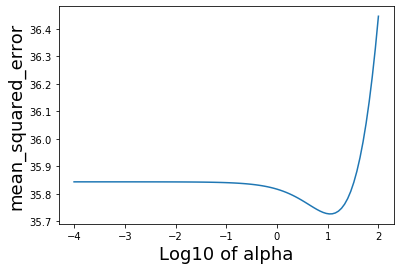

In [16]:
plt.plot(np.linspace(2, -4, 100),-ridge_grid_search.cv_results_["mean_test_score"])
plt.xlabel("Log10 of alpha", fontsize=18)
plt.ylabel("mean_squared_error", fontsize=18)
plt.show()

In [17]:
ridge_grid_search.best_params_

{'alpha': 10.722672220103231}

In [18]:
ridge_mod = get_shrinkage_mod(X_train,y_train,[ridge_grid_search.best_params_['alpha']],methods = 1,return_type = 2)
ridge_mod

lambda      coef                                                    \
               Intercept        zn     indus      chas       nox        rm   
idx                                                                          
1.0  10.722672  6.334246  0.030905 -0.070843 -0.871108 -5.170796  0.614234   

                                                                          \
          age       dis       rad       tax   ptratio     black    lstat   
idx                                                                        
1.0 -0.011409 -0.732357  0.465412  0.000359 -0.180985 -0.001411  0.19594   

               
         medv  
idx            
1.0 -0.139803

**PCR方法**

In [19]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
pca_lr = Pipeline([
("pca", PCA()),
("lr", linear_model.LinearRegression())
])
param_grid = [
{'pca__n_components': np.arange(1,14) },
]
pca_grid_search = GridSearchCV(pca_lr, param_grid, cv = 10, scoring='neg_mean_squared_error')
pca_grid_search.fit(X_train_Standard ,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('lr',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'pca__n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 1

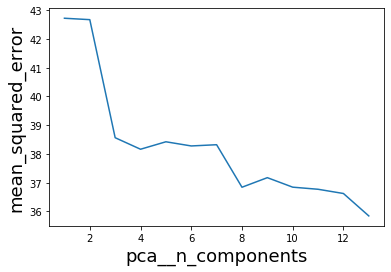

In [20]:
plt.plot(np.arange(1,14),-pca_grid_search.cv_results_["mean_test_score"])
plt.xlabel("pca__n_components", fontsize=18)
plt.ylabel("mean_squared_error", fontsize=18)
plt.show()

In [21]:
pca_grid_search.best_params_

{'pca__n_components': 13}

**PLS方法(原题未要求)**

In [22]:
from sklearn.cross_decomposition import PLSRegression
np.random.seed(1)
param_grid = [
{'n_components': np.arange(1,14) },
]
pls = PLSRegression()
pls_grid_search = GridSearchCV(pls, param_grid, cv = 10, scoring='neg_mean_squared_error')
pls_grid_search.fit(X_train_Standard ,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=PLSRegression(copy=True, max_iter=500, n_components=2,
                                     scale=True, tol=1e-06),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

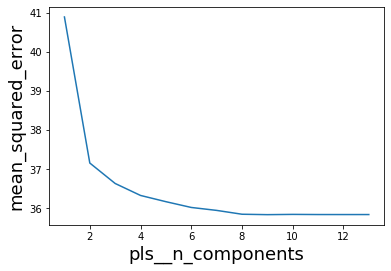

In [23]:
plt.plot(np.arange(1,14),-pls_grid_search.cv_results_["mean_test_score"])
plt.xlabel("pls__n_components", fontsize=18)
plt.ylabel("mean_squared_error", fontsize=18)
plt.show()

In [24]:
pls_grid_search.best_params_

{'n_components': 9}

**(b) Propose a model (or set of models) that seem to perform well on
this data set, and justify your answer. Make sure that you are
evaluating model performance using validation set error, cross-
validation, or some other reasonable alternative, as opposed to
using training error.**

**最优子集法数据在验证集上的全部效果**

In [25]:
from sklearn.metrics import mean_squared_error
mse_test_list = []
for num_of_pre in num_range:
    reg_line = reg.loc[num_of_pre]
    y_predict = reg_line['params'][reg_line['X_columns']].dot(X_test[reg_line['X_columns']].T) + reg_line['params']['const']
    mse_test_list.append(mean_squared_error(y_test, y_predict))
mse_test = pd.DataFrame(mse_test_list,index = num_range)

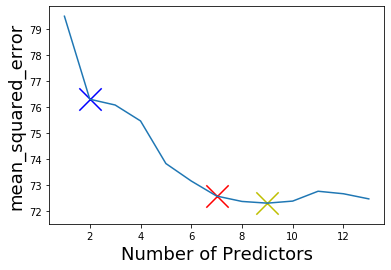

In [26]:
plt.plot(num_range,mse_test)
plt.xlabel("Number of Predictors", fontsize=18)
plt.ylabel("mean_squared_error", fontsize=18)
plt.scatter(reg_num_cp,mse_test.loc[reg_num_cp],marker = 'x',s=500,color = 'r')
plt.scatter(reg_num_bic,mse_test.loc[reg_num_bic],marker = 'x',s=500,color = 'b')
plt.scatter(reg_num_adjr2,mse_test.loc[reg_num_adjr2],marker = 'x',s=500,color = 'y')
plt.show()

In [27]:
#选择黄色即通过调整R2（adjusted r2）选择的最优子集模型最佳，这里把3钟模型测试MSE单独选择出来
test_mse_cp = float(mse_test.loc[reg_num_cp])
test_mse_bic =  float(mse_test.loc[reg_num_bic])
test_mse_adjr2 =  float(mse_test.loc[reg_num_adjr2])
print('test_mse_cp:',test_mse_cp)
print('test_mse_bic:',test_mse_bic)
print('test_mse_adjr2:',test_mse_adjr2)

test_mse_cp: 72.57726270553945
test_mse_bic: 76.30541323507609
test_mse_adjr2: 72.30407687265397


**lasso法数据在验证集上的全部效果**

In [28]:
X_test_Standard = std_scaler.transform(X_test)
y_predictions_lasso = lasso_grid_search.predict(X_test_Standard)
test_mse_lasso = mean_squared_error(y_test, y_predictions_lasso)
test_mse_lasso

73.23674637449693

**ridge法数据在验证集上的全部效果**

In [29]:
y_predictions_ridge = ridge_grid_search.predict(X_test_Standard)
test_mse_ridge = mean_squared_error(y_test, y_predictions_ridge)
test_mse_ridge

72.95479206788106

**PCR方法数据在验证集上的全部效果**

In [30]:
y_predictions_pca = pca_grid_search.predict(X_test_Standard)
test_mse_pca = mean_squared_error(y_test, y_predictions_pca)
test_mse_pca

72.46837018263321

**PLS方法数据在验证集上的全部效果（原题未要求）**

In [31]:
y_predictions_pls = pls_grid_search.predict(X_test_Standard)
test_mse_pls = mean_squared_error(y_test, y_predictions_pls)
test_mse_pls

72.34305456216676

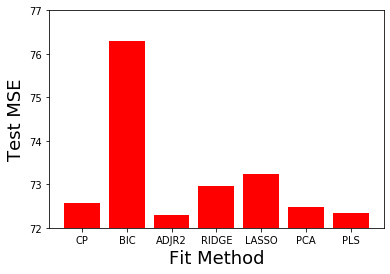

In [32]:
method_list = ['CP','BIC','ADJR2','RIDGE','LASSO','PCA','PLS']
R2_list = [test_mse_cp,test_mse_bic,test_mse_adjr2,test_mse_ridge,test_mse_lasso,test_mse_pca,test_mse_pls]
plt.bar(method_list,R2_list,color = 'red')
plt.ylim(72,77)
plt.xlabel("Fit Method", fontsize=18)
plt.ylabel("Test MSE", fontsize=18)
plt.show()

**(c) Does your chosen model involve all of the features in the data
set? Why or why not?**

**最优子集法（ADJR2判定）以及PLS法好于其他方法，选择最优子集法（ADJR2判定）只需要9个特征模型**

In [33]:
reg.loc[reg_num_adjr2]['params']

const      9.582721
zn         0.035445
indus     -0.088922
nox       -8.908480
rm         0.612342
dis       -0.824033
rad        0.508999
ptratio   -0.251722
lstat      0.175569
medv      -0.171445
dtype: float64